<h1> Data Cleansing <h1/>

In [40]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
import os
import seaborn as sns
import statsmodels.api as sm
import pylab as py

# seaborn graphics settings
sns.set(color_codes=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Show current working directory
print(os.getcwd())

C:\Users\AnninaBerweger\datascience-immo\Immo-Projekt-DataScience


<h3> DB Connection SQL Server <h3/>

In [41]:
#DB-Connection 
driver = '{ODBC Driver 17 for SQL Server}' # This might be a different version on your system
server = 'ANNINAYOGA\SQLEXPRESS'
database = 'Immo'
username = 'immoadmin'
password = 'zhaw$1234'
connection_string = f"DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;"

In [42]:
#Connection and SQL-Query for table property
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM property"
df_property = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]
cnxn.close()

#Connection and SQL-Query for table location
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM location"
df_location = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]
cnxn.close()

# Performing a inner join on the two DataFrames to filter data which do not exist on location due to connection issues
df_filtered_property_location = pd.merge(df_property, df_location,on='LocationId', how='inner')


<h3>DB Connection MYSQL<h3/>

In [4]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection details
db_config = {
    'host': '127.0.0.1',
    'port': '13306',
    'user': 'admin',
    'password': 'admin123',
    'database': 'immo'
}

# Create the engine
engine = create_engine(f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

# Querying the property table
query_property = "SELECT * FROM Property"
df_property = pd.read_sql(query_property, engine)

# Querying the location table
query_location = "SELECT * FROM Location"
df_location = pd.read_sql(query_location, engine)

# Performing an inner join on the two DataFrames
df_filtered_property_location = pd.merge(df_property, df_location, on='LocationId', how='inner')

# Close the connection
engine.dispose()


ModuleNotFoundError: No module named 'mysql'

# Data Cleansing for Location-Property

In [43]:
#Show head of df df_filtered_property_location
df_filtered_property_location.head()

,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,bfs_number,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count
0,4000339592,2024-03-26 20:51:38,2.5,93.0,1,Sofort,Wohnung,2020-01-01,1920.0,NaN,...,5254,Mendrisio,97,77,97,77,468,1,0,0
1,4000280848,2024-03-26 20:51:50,2.5,62.0,2,Sofort,Wohnung,2017-01-01,1730.0,280.0,...,5263,Riva San Vitale,97,80,97,80,437,5,1,3
2,4000653378,2024-03-26 21:52:37,2.0,58.0,3,Nach Vereinbarung,Wohnung,None,910.0,160.0,...,5257,Morbio Inferiore,97,84,97,84,1'999,6,0,2
3,4000381531,2024-03-26 22:44:33,1.5,40.0,None,Sofort,Wohnung,None,1350.0,100.0,...,5192,Lugano,97,77,97,77,825,4,0,3
4,4000263143,2024-03-26 20:52:41,2.5,50.0,99,Nach Vereinbarung,Wohnung,None,1300.0,NaN,...,5154,Bissone,97,69,97,69,491,1,0,0


In [44]:
#Show info of df df_filtered_property_location. Total of 11289 entries
df_filtered_property_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11289 entries, 0 to 11288
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     11289 non-null  object        
 1   Timestamp                     11289 non-null  datetime64[ns]
 2   Rooms                         10890 non-null  float64       
 3   SquareMeter                   9291 non-null   float64       
 4   Floor                         9573 non-null   object        
 5   Availability                  11288 non-null  object        
 6   ObjectType                    11288 non-null  object        
 7   YearBuilt                     4966 non-null   object        
 8   Price                         11289 non-null  float64       
 9   AdditionalCost                9265 non-null   float64       
 10  NetPrice                      10050 non-null  float64       
 11  LocationId                  

In [45]:
#Check for duplicates - no duplicates found
df_filtered_property_location.duplicated().sum()

0

# Check for empty entries and filter records

In [46]:
#dataframe df_filtered_property_location_clean  
#ObjectType where Einzelzimmer, Estrichabteil, Hobbyraum, Kellerabteil - filtered
#Rooms where NULL - filtered
#SquareMeter where NULL - filtered
#total: 9024 entries (original: 11298 entries)
#Outliers - check Outliers of Prices, Rooms and SquareMeters. Eliminate manually where not noisy data 
#total after eliminating noisy data: 9000 entries (original 11295 entries)

In [47]:
# filter out records with empty strings in the 'Rooms' column - new dataframe: df_filtered_property_location_clean
df_filtered_property_location_clean = df_filtered_property_location[df_filtered_property_location['Rooms'].notna()]

In [48]:
#Check ObjectTypes
df_filtered_property_location.groupby("ObjectType").size()

ObjectType
Attikawohnung             318
Bauernhaus                  6
Chalet                     40
Dachwohnung               300
Doppeleinfamilienhaus      28
Einfamilienhaus           281
Einliegerwohnung            9
Einzelzimmer               98
Estrichabteil               2
Hobbyraum                 122
Kellerabteil               11
Loft                       71
Maisonette / Duplex       359
Mansarde                    1
Mehrfamilienhaus            2
Reihenfamilienhaus         58
Studio                    151
Terrassenhaus               4
Terrassenwohnung           38
Villa                      66
Wohnung                  9323
dtype: int64

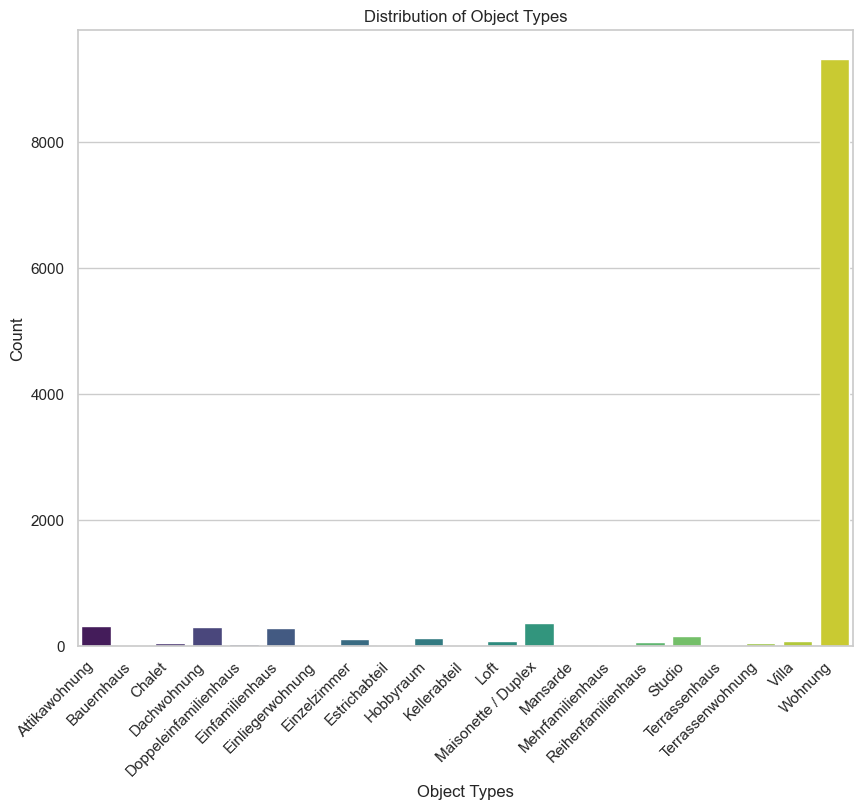

In [49]:
# Group the DataFrame by 'ObjectType' and calculate the size of each group
object_type_counts = df_filtered_property_location.groupby('ObjectType').size().reset_index(name='counts')

# Now use Seaborn to create a barplot
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='ObjectType', y='counts', data=object_type_counts, palette="viridis")

# Optional: Rotate the x labels if they overlap
plt.xticks(rotation=45, ha='right')

plt.title('Distribution of Object Types')
plt.xlabel('Object Types')
plt.ylabel('Count')
plt.show()


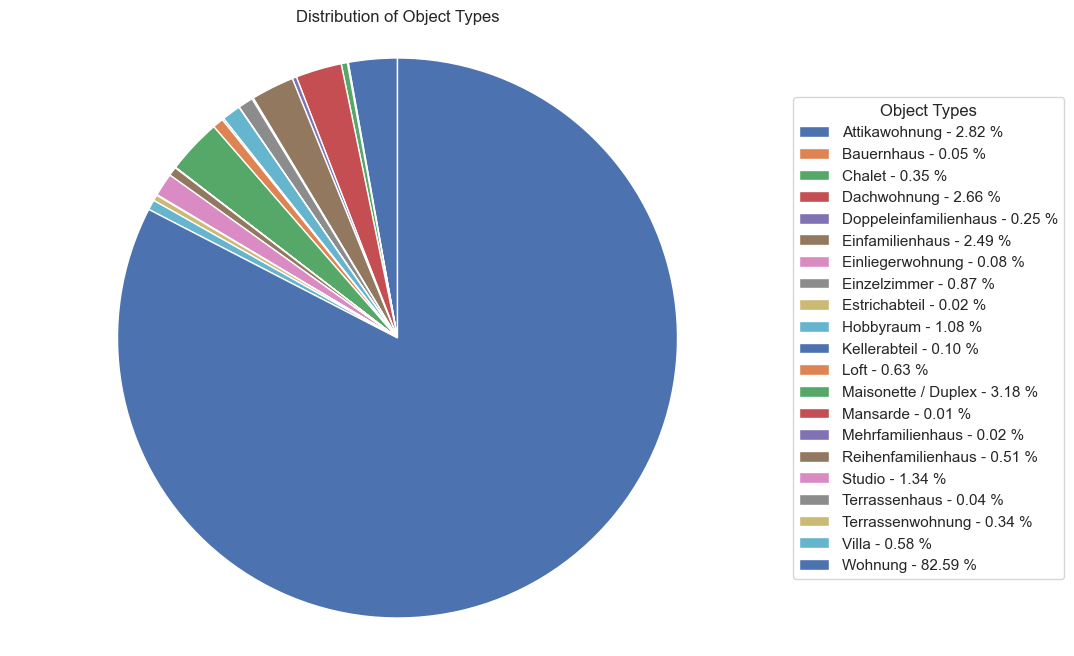

In [50]:
object_type_counts = df_filtered_property_location.groupby('ObjectType').size()

# Calculate percentages
percentages = 100 * object_type_counts / object_type_counts.sum()

# Create labels for the legend with percentages
legend_labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(object_type_counts.index, percentages)]

# Apply Seaborn style
sns.set(style="whitegrid")

# Create a pie chart
plt.figure(figsize=(10, 8))
patches, texts = plt.pie(object_type_counts, labels=None, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Place the legend with the percentages labels
plt.legend(patches, legend_labels, title="Object Types", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title('Distribution of Object Types')
plt.show()

In [51]:
#Filter where ObjectType != Einzelzimmer, Estrichabteil, Hobbyraum or Kellerabteil
df_filtered_property_location_clean = df_filtered_property_location[(df_filtered_property_location['ObjectType'] != 'Einzelzimmer') & (df_filtered_property_location['ObjectType'] != 'Estrichabteil') & (df_filtered_property_location['ObjectType'] != 'Hobbyraum') & (df_filtered_property_location['ObjectType'] != 'Kellerabteil')]

#Check ObjectTypes - Einzelzimmer, Estrichabteil, Hobbyraum or Kellerabteil are filtered
df_filtered_property_location_clean.groupby("ObjectType").size()

ObjectType
Attikawohnung             318
Bauernhaus                  6
Chalet                     40
Dachwohnung               300
Doppeleinfamilienhaus      28
Einfamilienhaus           281
Einliegerwohnung            9
Loft                       71
Maisonette / Duplex       359
Mansarde                    1
Mehrfamilienhaus            2
Reihenfamilienhaus         58
Studio                    151
Terrassenhaus               4
Terrassenwohnung           38
Villa                      66
Wohnung                  9323
dtype: int64

In [52]:
# filter out records with empty strings in the 'Rooms' and 'SquareMeters' column
df_filtered_property_location_clean = df_filtered_property_location.dropna(subset=['Rooms', 'SquareMeter'])

#Check for empty records
df_filtered_property_location_clean.isnull().sum()

ListingId                          0
Timestamp                          0
Rooms                              0
SquareMeter                        0
Floor                           1080
Availability                       0
ObjectType                         0
YearBuilt                       4426
Price                              0
AdditionalCost                  1481
NetPrice                         916
LocationId                         0
PropertyAdditionalFeaturesId       0
PropertyDescription               37
Vendor                           652
Canton                             0
street                           550
zip                                0
longitude                          0
latitude                           0
bfs_number                         0
municipality                       0
incometax_canton                   0
incometax_municipality             0
wealthtax_canton                   0
wealthtax_municipality             0
population_density                47
p

In [54]:
#9019 entries after filtered
df_filtered_property_location_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9019 entries, 0 to 11288
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     9019 non-null   object        
 1   Timestamp                     9019 non-null   datetime64[ns]
 2   Rooms                         9019 non-null   float64       
 3   SquareMeter                   9019 non-null   float64       
 4   Floor                         7939 non-null   object        
 5   Availability                  9019 non-null   object        
 6   ObjectType                    9019 non-null   object        
 7   YearBuilt                     4593 non-null   object        
 8   Price                         9019 non-null   float64       
 9   AdditionalCost                7538 non-null   float64       
 10  NetPrice                      8103 non-null   float64       
 11  LocationId                    9019

<Axes: xlabel='SquareMeter'>

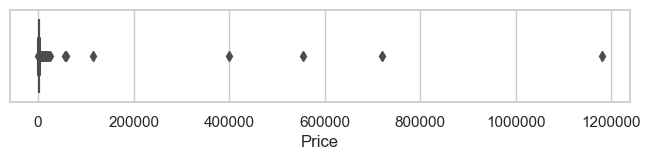

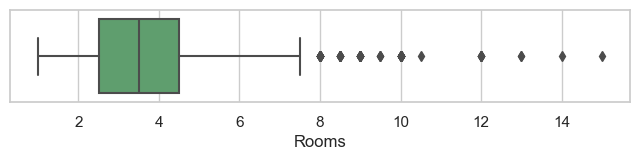

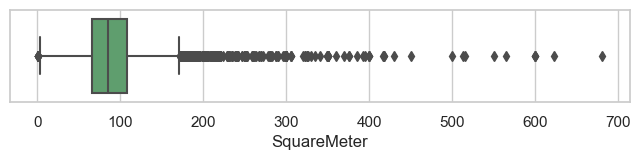

In [55]:
#Boxplots for Outliers of Prices, Rooms and SquareMeters
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Price'], color="g")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Rooms'], color="g")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['SquareMeter'], color="g")

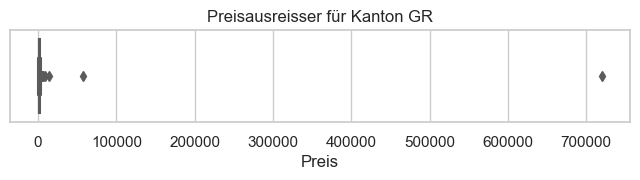

In [56]:
#Show outlier for specific canton
df_gr = df_filtered_property_location_clean[df_filtered_property_location_clean['Canton'] == 'gr']
plt.figure(figsize=(8, 1.2))
plt.ticklabel_format(style='plain')  # Stellt sicher, dass die Preise im normalen Zahlenformat angezeigt werden
sns.boxplot(x=df_gr['Price'], color="greenyellow")  # Erstellen des Boxplots mit der angegebenen Farbe

plt.title('Preisausreisser für Kanton GR')  # Hinzufügen eines Titels zum Plot
plt.xlabel('Preis')  # Beschriftung der X-Achse
plt.show()

In [57]:
#Detect outliers (Price) and list them

# Set display options
pd.set_option('display.max_rows', 50)

# Calculation of the first (Q1) and third quartiles (Q3) for Price across the entire DataFrame
Q1 = df_filtered_property_location_clean['Price'].quantile(0.25)
Q3 = df_filtered_property_location_clean['Price'].quantile(0.75)
IQR = Q3 - Q1

# Boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = df_filtered_property_location_clean[(df_filtered_property_location_clean['Price'] < lower_bound) | (df_filtered_property_location_clean['Price'] > upper_bound)]

# Feedback if there are any outliers
if outliers.empty:
    print("No outliers found.")
else:
    # Sort outliers by the 'Price' column in descending order
    outliers_sorted = outliers.sort_values(by='Price', ascending=False)
    
    # Display sorted outliers
    print("Outliers found, sorted by highest price:")
    display(outliers_sorted)


Outliers found, sorted by highest price:


,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,bfs_number,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count
9841,4000895043,2024-03-29 14:01:53,4.5,92.0,EG,15.12.2024,Wohnung,None,1180000.0,NaN,...,5422,Aubonne,155,70,155,70,265,3,1,4
7409,4000956535,2024-03-27 14:46:17,3.5,139.0,EG,Nach Vereinbarung,Wohnung,1965-01-01,720000.0,NaN,...,3847,Val Müstair,100,120,100,120,7,2,0,1
8301,4000834270,2024-03-26 05:49:47,2.5,67.0,EG,31.03.2027,Wohnung,2024-01-01,554000.0,NaN,...,5266,Stabio,97,65,97,65,733,5,2,2
7880,4000895759,2024-03-25 21:29:48,2.5,63.0,EG,Sofort,Wohnung,2023-01-01,399000.0,NaN,...,5239,Tresa,97,85,97,85,None,2,0,0
6201,3003516605,2024-03-24 13:08:32,10.0,350.0,None,Sofort,Chalet,1930-01-01,115000.0,NaN,...,843,Saanen,302.5,120,302.5,120,57,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3467,4000887932,2024-03-27 21:59:19,4.5,110.0,5,Sofort,Attikawohnung,2024-01-01,3690.0,250.0,...,4021,Baden,112,92,112,92,1'484,4,1,2
10989,4000871115,2024-03-29 21:54:59,5.0,116.0,1,Nach Vereinbarung,Wohnung,None,3690.0,190.0,...,6619,Corsier (GE),147.5,34,147.5,34,798,2,0,1
5324,4000890770,2024-03-24 02:59:08,4.5,133.0,-1,Nach Vereinbarung,Wohnung,2023-01-01,3690.0,330.0,...,227,Seuzach,99,99,99,99,984,4,2,3
4970,4000888372,2024-03-24 01:48:25,4.5,132.0,None,Nach Vereinbarung,Wohnung,None,3690.0,450.0,...,247,Schlieren,99,111,99,111,2'851,3,3,11


In [58]:
#Detect outliers (Rooms) and list them

# Set display options
pd.set_option('display.max_rows', 500)

# Calculation of the first (Q1) and third quartiles (Q3) for Price across the entire DataFrame
Q1 = df_filtered_property_location_clean['Rooms'].quantile(0.25)
Q3 = df_filtered_property_location_clean['Rooms'].quantile(0.75)
IQR = Q3 - Q1

# Boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = df_filtered_property_location_clean[(df_filtered_property_location_clean['Price'] < lower_bound) | (df_filtered_property_location_clean['Price'] > upper_bound)]

# Feedback if there are any outliers
if outliers.empty:
    print("No outliers found.")
else:
    # Sort the outliers by the 'Price' column in descending order
    outliers_sorted = outliers.sort_values(by='Rooms', ascending=False)
    
    # Display the sorted outliers
    print("Outliers found, sorted by highest Rooms:")
    display(outliers_sorted)

Outliers found, sorted by highest Rooms:


,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,bfs_number,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count
8092,4000747603,2024-03-26 23:12:08,15.0,43.0,99,Nach Vereinbarung,Wohnung,None,2900.0,NaN,...,5192,Lugano,97,77,97,77,825,8,2,14
3077,4000360406,2024-03-26 22:45:34,14.0,416.0,None,Nach Vereinbarung,Wohnung,None,6760.0,NaN,...,5257,Morbio Inferiore,97,84,97,84,1'999,4,0,1
11140,4000853321,2024-03-29 22:28:33,13.0,418.0,3,Sofort,Wohnung,None,12700.0,800.0,...,6621,Genève,147.5,45.49,147.5,45.49,12'811,6,3,7
11154,4000976047,2024-03-29 22:33:07,13.0,418.0,None,Nach Vereinbarung,Wohnung,None,12200.0,800.0,...,6621,Genève,147.5,45.49,147.5,45.49,12'811,8,2,12
2988,4000945500,2024-03-27 13:03:53,12.0,340.0,None,Sofort,Einfamilienhaus,1938-01-01,4500.0,600.0,...,1102,Sempach,160,175,160,175,472,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,4000937788,2024-03-26 21:29:48,1.0,25.0,3,Sofort,Wohnung,None,680.0,80.0,...,5192,Lugano,97,77,97,77,825,11,2,11
10249,4000867718,2024-03-29 18:15:13,1.0,17.0,4,Sofort,Wohnung,None,600.0,50.0,...,6266,Sion,100,110,100,110,995,11,2,35
1280,4000161638,2024-03-27 17:20:03,1.0,48.0,2,Sofort,Studio,None,850.0,50.0,...,6790,Fontenais,285,235,285,235,85,3,0,0
7929,3003296216,2024-03-27 10:21:38,1.0,24.0,1,Sofort,Wohnung,2022-01-01,1090.0,90.0,...,1372,Schwyz,120,205,120,205,287,4,3,3


In [59]:
#detect outliers (SquareMeter) and list them

# Set display options
pd.set_option('display.max_rows', 50)

# Calculation of the first (Q1) and third quartiles (Q3) for Price across the entire DataFrame
Q1 = df_filtered_property_location_clean['SquareMeter'].quantile(0.25)
Q3 = df_filtered_property_location_clean['SquareMeter'].quantile(0.75)
IQR = Q3 - Q1

# Boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = df_filtered_property_location_clean[(df_filtered_property_location_clean['SquareMeter'] < lower_bound) | (df_filtered_property_location_clean['Price'] > upper_bound)]

# Feedback if there are any outliers
if outliers.empty:
    print("No outliers found.")
else:
    # Sort the outliers by the 'Price' column in descending order
    outliers_sorted = outliers.sort_values(by='SquareMeter', ascending=False)
    
    # Display the sorted outliers
    print("Outliers found, sorted by highest SquareMeter:")
    display(outliers_sorted)

Outliers found, sorted by highest SquareMeter:


,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,bfs_number,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count
88,4000634700,2024-03-26 21:53:23,6.5,680.0,EG,Nach Vereinbarung,Villa,2012-01-01,20000.0,NaN,...,5176,Comano,97,75,97,75,994,0,0,0
2687,4000869508,2024-03-27 08:42:30,10.0,622.0,None,Nach Vereinbarung,Villa,1986-01-01,9900.0,NaN,...,3024,Teufen (AR),330,260,330,260,417,2,0,1
10245,4000943404,2024-03-29 18:13:13,12.0,600.0,None,Nach Vereinbarung,Chalet,None,13000.0,NaN,...,6240,Lens,100,105,100,105,302,3,0,0
8221,4000611388,2024-03-25 22:19:29,7.5,600.0,None,Nach Vereinbarung,Einfamilienhaus,None,18000.0,NaN,...,5192,Lugano,97,77,97,77,825,19,0,44
9920,3000029481,2024-03-29 14:20:24,8.0,600.0,None,Sofort,Chalet,2008-01-01,10000.0,NaN,...,1406,Sachseln,335,470,335,470,96,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5542,4000931326,2024-03-24 03:33:00,4.5,1.0,2,01.04.2024,Wohnung,1898-01-01,1699.0,510.0,...,295,Horgen,99,90,99,90,746,4,0,2
3108,4000906960,2024-03-27 10:41:49,1.0,1.0,1,Sofort,Einzelzimmer,None,828.0,NaN,...,1322,Freienbach,120,74,120,74,1'196,7,2,4
8520,4000969684,2024-03-29 08:41:29,3.0,1.0,1,01.05.2024,Wohnung,None,1740.0,NaN,...,2254,Courtepin,96,85,100,85,250,1,3,1
3524,4000962388,2024-03-27 22:14:14,2.5,1.0,EG,01.07.2024,Wohnung,None,1254.0,160.0,...,4141,Reinach (AG),112,115,112,115,927,4,2,10


In [60]:
#Outliers manually checked if records is valid or not (if not valid (selling house instead of renting), to delete
# List of ListingIds to be removed (selling instead of renting objects, shared apartments,...)
ids_to_remove = ['4000895043','4000834270','4000895759','3003516605','4000910516','4000956535','4000924121','4000975051','4000888412','4000945522','4000869481','4000969667','4000838419','4000870455','4000904681','4000931326','4000969684','4000969684','4000797599','4000897187','4000969553','4000969553','4000965774','4000962388','4000969516','4000906960']  
df_filtered_property_location_clean = df_filtered_property_location_clean[~df_filtered_property_location_clean['ListingId'].isin(ids_to_remove)]


In [61]:
#8995 entries after filtered
df_filtered_property_location_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8995 entries, 0 to 11288
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     8995 non-null   object        
 1   Timestamp                     8995 non-null   datetime64[ns]
 2   Rooms                         8995 non-null   float64       
 3   SquareMeter                   8995 non-null   float64       
 4   Floor                         7918 non-null   object        
 5   Availability                  8995 non-null   object        
 6   ObjectType                    8995 non-null   object        
 7   YearBuilt                     4585 non-null   object        
 8   Price                         8995 non-null   float64       
 9   AdditionalCost                7530 non-null   float64       
 10  NetPrice                      8092 non-null   float64       
 11  LocationId                    8995

<Axes: xlabel='SquareMeter'>

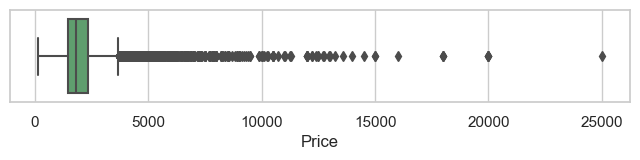

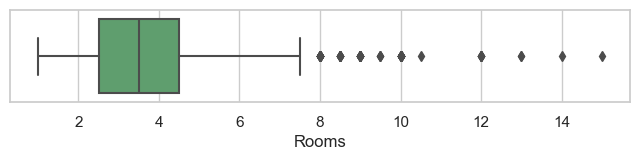

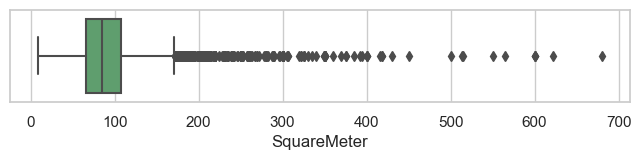

In [62]:
#Boxplots after eliminating noisy data for Outliers of Prices, Rooms and SquareMeters
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Price'], color="g")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Rooms'], color="g")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['SquareMeter'], color="g")

# Data Cleansing for PropertyAdditionalFeatures

In [63]:
#Connection
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM PropertyAdditionalFeatures"
df_data_PropertyAdditionalFeatures = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]

cnxn.close()

In [64]:
#Show header of table
df_data_PropertyAdditionalFeatures.head()

,ListingId,Feature
0,044f5ac4-3a33-436e-a004-09a0a6855fbf,Kinderfreundlich
1,044f5ac4-3a33-436e-a004-09a0a6855fbf,Parkplatz
2,b30f81ac-a527-4996-9d69-2522870131c6,Haustiere erlaubt
3,b30f81ac-a527-4996-9d69-2522870131c6,Balkon / Terrasse
4,b30f81ac-a527-4996-9d69-2522870131c6,Kabel-TV


In [65]:
# Check for duplicates - no duplicates found
df_data_PropertyAdditionalFeatures.duplicated()
df_data_PropertyAdditionalFeatures.duplicated().sum()

0

In [66]:
# Check for empty entries - no empty entries found
df_data_PropertyAdditionalFeatures.isnull().sum()

ListingId    0
Feature      0
dtype: int64

# Enrich Data

In [67]:
# Adding the new column 'Price_per_m2'
df_filtered_property_location_clean['Price_per_m2'] = df_filtered_property_location_clean['Price'] / df_filtered_property_location_clean['SquareMeter']

# Check the DataFrame to confirm the new column has been added
print(df_filtered_property_location_clean.head())

    ListingId           Timestamp  Rooms  SquareMeter Floor  \
0  4000339592 2024-03-26 20:51:38    2.5         93.0     1   
1  4000280848 2024-03-26 20:51:50    2.5         62.0     2   
2  4000653378 2024-03-26 21:52:37    2.0         58.0     3   
3  4000381531 2024-03-26 22:44:33    1.5         40.0  None   
4  4000263143 2024-03-26 20:52:41    2.5         50.0    99   

        Availability ObjectType   YearBuilt   Price  AdditionalCost  ...  \
0             Sofort    Wohnung  2020-01-01  1920.0             NaN  ...   
1             Sofort    Wohnung  2017-01-01  1730.0           280.0  ...   
2  Nach Vereinbarung    Wohnung        None   910.0           160.0  ...   
3             Sofort    Wohnung        None  1350.0           100.0  ...   
4  Nach Vereinbarung    Wohnung        None  1300.0             NaN  ...   

       municipality incometax_canton incometax_municipality wealthtax_canton  \
0         Mendrisio       97                     77               97           
1   

In [73]:
df_filtered_property_location_clean.head()

,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count,Price_per_m2
0,4000339592,2024-03-26 20:51:38,2.5,93.0,1,Sofort,Wohnung,2020-01-01,1920.0,NaN,...,Mendrisio,97,77,97,77,468,1,0,0,20.645161
1,4000280848,2024-03-26 20:51:50,2.5,62.0,2,Sofort,Wohnung,2017-01-01,1730.0,280.0,...,Riva San Vitale,97,80,97,80,437,5,1,3,27.903226
2,4000653378,2024-03-26 21:52:37,2.0,58.0,3,Nach Vereinbarung,Wohnung,None,910.0,160.0,...,Morbio Inferiore,97,84,97,84,1'999,6,0,2,15.689655
3,4000381531,2024-03-26 22:44:33,1.5,40.0,None,Sofort,Wohnung,None,1350.0,100.0,...,Lugano,97,77,97,77,825,4,0,3,33.750000
4,4000263143,2024-03-26 20:52:41,2.5,50.0,99,Nach Vereinbarung,Wohnung,None,1300.0,NaN,...,Bissone,97,69,97,69,491,1,0,0,26.000000


In [75]:
# Trimmen aller String-Spalten im DataFrame
for col in df_filtered_property_location_clean.columns:
    if df_filtered_property_location_clean[col].dtype == 'object':
        df_filtered_property_location_clean[col] = df_filtered_property_location_clean[col].apply(lambda x: x.strip() if isinstance(x, str) else x)

# Dateiname festlegen
filename = 'filtered_property_location_clean.csv'

# Überprüfen, ob die Datei bereits existiert
if os.path.exists(filename):
    print(f"Warnung: Die Datei '{filename}' existiert bereits und wird überschrieben.")

# DataFrame als CSV-Datei speichern
df_filtered_property_location_clean.to_csv(filename, index=False, sep=';')

print(f"DataFrame wurde erfolgreich als {filename} gespeichert.")


Warnung: Die Datei 'filtered_property_location_clean.csv' existiert bereits und wird überschrieben.
DataFrame wurde erfolgreich als filtered_property_location_clean.csv gespeichert.


# EDA

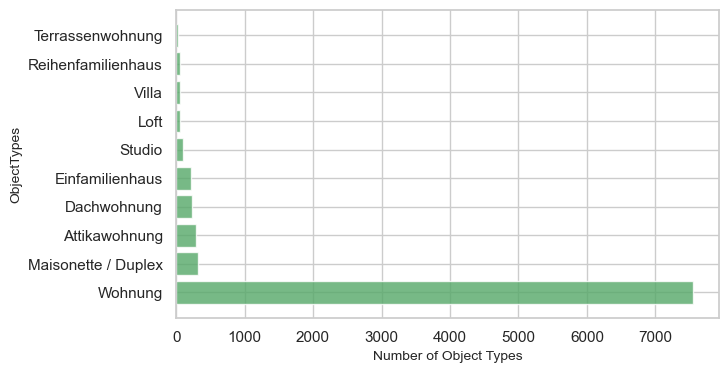

In [29]:
# Barchart top 10 ObjectTypes
#Group data by ObjectType (only the topmost 10 values are shown)
df_bar_property = df_filtered_property_location_clean['ObjectType'].value_counts().nlargest(10).sort_values(ascending=False)

# Values for barchart
napart = list(df_bar_property.values)
index = list(df_bar_property.index.values)
y_pos = np.arange(len(index))

# Figure
fig, ax = plt.subplots(figsize=(7,4))
ax.barh(y_pos, napart, align='center', color='g', alpha=0.8)
ax.set_yticks(y_pos, index)
ax.set_xlabel('Number of Object Types', fontsize=10)
ax.set_ylabel('ObjectTypes', fontsize=10)

# Show graph
plt.show()

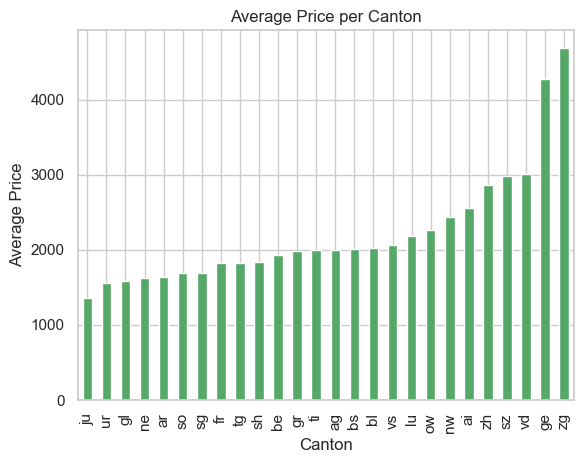

In [30]:
#Barplot average price / canton

average_prices = df_filtered_property_location_clean.groupby('Canton')['Price'].mean().sort_values()
average_prices.plot(kind='bar',color='g')
plt.title('Average Price per Canton')
plt.xlabel('Canton')
plt.ylabel('Average Price')

plt.show()

In [31]:
#Summary statistics of numeric variables
df_filtered_property_location_clean.describe()

,Timestamp,Rooms,SquareMeter,Price,AdditionalCost,NetPrice,zip,Price_per_m2
count,8995,8995.000000,8995.000000,8995.000000,7530.000000,8092.000000,8995.000000,8995.000000
mean,2024-03-27 10:50:21.606336768,3.607560,92.238243,2128.323735,241.070784,1870.930672,5317.283936,24.232967
min,2024-03-24 00:40:41,1.000000,9.000000,140.000000,1.000000,80.000000,1000.000000,2.000000
25%,2024-03-24 18:07:43.500000,2.500000,66.000000,1460.000000,180.000000,1260.000000,3011.000000,18.398113
50%,2024-03-27 16:41:51,3.500000,85.000000,1820.000000,230.000000,1590.000000,5033.000000,21.875000
75%,2024-03-29 09:50:08,4.500000,108.000000,2350.000000,290.000000,2050.000000,8050.000000,27.037037
max,2024-03-29 23:07:44,15.000000,680.000000,25000.000000,2550.000000,20000.000000,9657.000000,228.000000
std,NaN,1.302769,45.780306,1361.003418,102.174749,1235.528969,2645.633410,10.188650


In [32]:
#Skewness
df_filtered_property_location_clean[['Price','Rooms', 'SquareMeter']].skew()

Price          4.973414
Rooms          0.942203
SquareMeter    2.998926
dtype: float64

In [33]:
#Kurtosis
df_filtered_property_location_clean[['Price','Rooms', 'SquareMeter']].kurtosis()

Price          43.357637
Rooms           4.407364
SquareMeter    20.570338
dtype: float64

In [34]:
#Extreme values

# Low costs apartments
df_filtered_property_location_clean[df_filtered_property_location_clean['Price_per_m2'] <= 10]

# Very expensive apartments
df_filtered_property_location_clean[df_filtered_property_location_clean['Price_per_m2'] >= 100]

,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count,Price_per_m2
1699,4000857273,2024-03-27 13:52:45,7.5,230.0,None,Nach Vereinbarung,Einfamilienhaus,None,25000.0,NaN,...,Horw,160,145,160,145,1'108,2,0,0,108.695652
1702,4000465081,2024-03-29 22:19:24,1.0,25.0,5,Sofort,Wohnung,None,2700.0,NaN,...,GenÃ¨ve,147.5,45.49,147.5,45.49,12'811,10,9,79,108.000000
4947,4000920597,2024-03-24 01:42:30,3.0,36.0,4,Sofort,Dachwohnung,2023-01-01,4120.0,NaN,...,ZÃ¼rich,99,119,99,119,4'779,7,3,27,114.444444
5240,3003168603,2024-03-24 02:44:06,2.0,32.0,None,Nach Vereinbarung,Wohnung,None,3519.0,129.0,...,ZÃ¼rich,99,119,99,119,4'779,10,1,35,109.968750
5405,3003169151,2024-03-24 03:15:30,2.0,46.0,None,Nach Vereinbarung,Wohnung,None,5076.0,186.0,...,ZÃ¼rich,99,119,99,119,4'779,7,4,76,110.347826
5408,3003169310,2024-03-24 03:14:31,2.0,37.0,None,Nach Vereinbarung,Wohnung,None,4142.0,152.0,...,ZÃ¼rich,99,119,99,119,4'779,9,5,126,111.945946
5428,3003168595,2024-03-24 03:17:41,1.0,36.0,None,Nach Vereinbarung,Wohnung,None,4246.0,156.0,...,ZÃ¼rich,99,119,99,119,4'779,7,4,76,117.944444
9696,4000969668,2024-03-29 13:26:53,2.0,9.0,1,01.08.2024,Einzelzimmer,None,900.0,100.0,...,Renens (VD),155,77,155,77,7'080,4,2,9,100.000000
10391,4000842714,2024-03-29 18:58:03,1.5,13.0,2,Sofort,Wohnung,2018-01-01,1530.0,NaN,...,Sion,100,110,100,110,995,4,0,3,117.692308
11091,4000665076,2024-03-29 22:18:16,1.0,15.0,1,Nach Vereinbarung,Wohnung,None,3420.0,NaN,...,GenÃ¨ve,147.5,45.49,147.5,45.49,12'811,12,7,85,228.000000


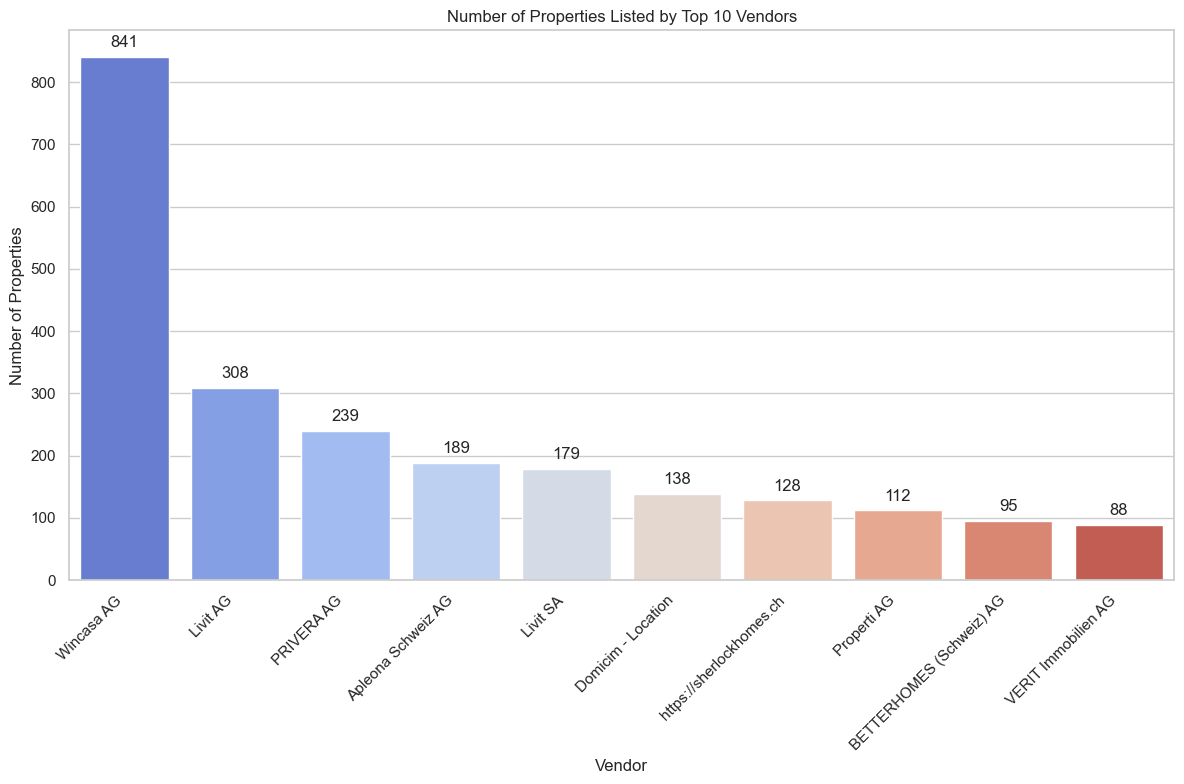

In [35]:
#Count of properties listed by each vendor-only top 10 vendors

# Calculate counts for each vendor
vendor_counts = df_filtered_property_location_clean['Vendor'].value_counts()

# Get the top 10 vendors
top_vendors = vendor_counts.nlargest(10).index

# Filter the DataFrame to include only rows with the top 10 vendors
top_vendors_data = df_filtered_property_location_clean[df_filtered_property_location_clean['Vendor'].isin(top_vendors)]

# Apply Seaborn style
sns.set(style="whitegrid")

# Create a count plot for the 'Vendor' column with only the top 10 vendors
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='Vendor', data=top_vendors_data, palette='coolwarm', order=top_vendors)

# Rotate the x labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Add a title and labels
plt.title('Number of Properties Listed by Top 10 Vendors')
plt.xlabel('Vendor')
plt.ylabel('Number of Properties')

# Optional: Annotate each bar with the count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()  # Adjust layout to fit the rotated x labels
plt.show()

In [37]:
#Multivariate non-graphical exploratory data analysis (EDA)
#Cross-tabulation
pd.crosstab(df_filtered_property_location_clean['SquareMeter'], df_filtered_property_location_clean['Price'])


Price,140.0,200.0,250.0,260.0,290.0,300.0,399.0,400.0,425.0,450.0,...,13000.0,13250.0,13600.0,14000.0,14500.0,15000.0,16000.0,18000.0,20000.0,25000.0
SquareMeter,,,,,,,,,,,,,,,,,,,,,
9.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10.0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11.0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13.0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
600.0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [38]:
# Crosstab of Rooms and Price (assuming 'Price' is categorized or binned for better visualization)
price_bins = pd.cut(df_filtered_property_location_clean['Price'], bins=8)  # Bins prices into 5 categories
rooms_vs_price = pd.crosstab(df_filtered_property_location_clean['Rooms'], price_bins)

# Display the crosstab
print(rooms_vs_price)

Price  (115.14, 3247.5]  (3247.5, 6355.0]  (6355.0, 9462.5]  \
Rooms                                                         
1.0                 332                 7                 0   
1.5                 270                 0                 0   
2.0                 415                19                 1   
2.5                1230                34                 0   
3.0                 737                18                 2   
3.5                2392               106                 6   
4.0                 438                55                 1   
4.5                1781               174                20   
5.0                  92                53                 4   
5.5                 322               108                13   
6.0                  30                43                 8   
6.5                  48                51                12   
7.0                   9                18                11   
7.5                   9                24              

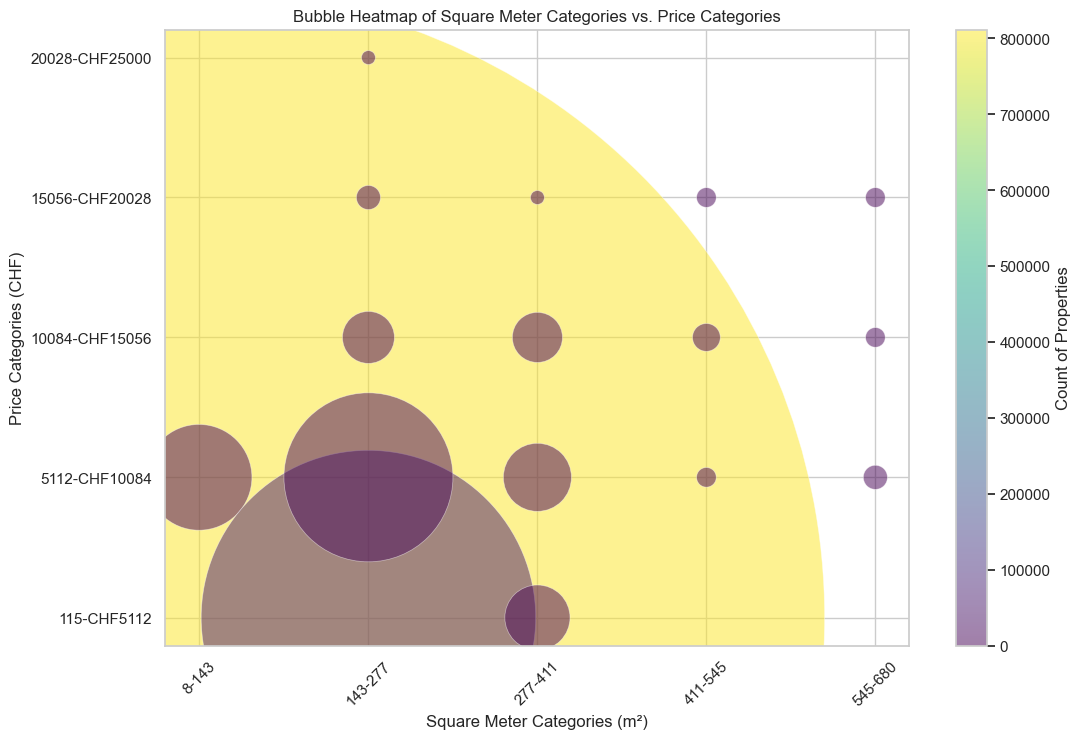

In [39]:
# Bin both SquareMeter and Price for a more manageable visualization
square_meter_bins = pd.cut(df_filtered_property_location_clean['SquareMeter'], bins=5)
price_bins = pd.cut(df_filtered_property_location_clean['Price'], bins=5)

# Create the crosstab
area_vs_price = pd.crosstab(square_meter_bins, price_bins)

# Obtain the mid values of each bin for accurate plotting
square_mid = [bin.mid for bin in square_meter_bins.cat.categories]
price_mid = [bin.mid for bin in price_bins.cat.categories]

# Generate coordinates for square meters and prices
square_meters = np.repeat(square_mid, len(price_mid))
prices = np.tile(price_mid, len(square_mid))

# Sizes for the bubbles based on the crosstab counts, scaled for better visualization
sizes = area_vs_price.values.flatten() * 100

# Create the bubble heatmap (scatter plot)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(square_meters, prices, s=sizes, alpha=0.5, cmap='viridis', c=sizes, edgecolors='w', linewidths=0.5)

# Create a color bar
plt.colorbar(scatter, label='Count of Properties')

# Add titles and labels
plt.title('Bubble Heatmap of Square Meter Categories vs. Price Categories')
plt.xlabel('Square Meter Categories (m²)')
plt.ylabel('Price Categories (CHF)')
plt.xticks(ticks=square_mid, labels=[f'{int(cat.left)}-{int(cat.right)}' for cat in square_meter_bins.cat.categories], rotation=45)
plt.yticks(ticks=price_mid, labels=[f'{int(cat.left)}-CHF{int(cat.right)}' for cat in price_bins.cat.categories])

# Show the plot
plt.show()